# Keras based GRU Network

## Prepare dataset

Reformat dataset to be int format
```
caption | valence_class
caption | {negative,neutral,positive}
```

In [1]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# fix random seed for reproducibility
seed = 7

captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root_path = pathlib.Path(captions_root)

human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

None


## Set Keras to use Tensorflow GPU in the backend

In [2]:
import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 2
    num_CPU = 8
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html    
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
    

In [3]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GRU, Bidirectional, LSTM
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Masking
from keras.layers.core import  ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from keras import regularizers
from keras.regularizers import L1L2
import keras
from sklearn.model_selection import KFold
import os
import io
import numpy as np
import tensorflow as tf
from gensim.models import word2vec
import pandas as pd
# from fastText import load_model
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing import text
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import StratifiedKFold

%matplotlib inline 

def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}


fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 999995
embedding dimension : (300,)


## Results

Epoch 300/300
663/663 [==============================] - 2s 3ms/step - loss: 0.1011 - acc: 0.9789 - val_loss: 1.9239 - val_acc: 0.6426

best_val_acc:  0.7148936180358237
filename adidas-0.7149-1527322080
Total time passed for training 9.198103360335033


0             two acorns lying ground next oak leaves.
1    three acorns flat surface. one acorn missing c...
2    five acorns arranged circle black background. ...
3    two cocktails brown wooden table. cocktail fro...
4                  three shelves full bottles whiskey.
Name: caption, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64
Label distribution:  label
-1    163
 0    420
 1    317
Name: label, dtype: int64
max_seq_len 38

TRAIN size: 719 	 VAL size: 181
TRAIN[:5]: [0 2 3 4 5] 	 VAL[:5]: [ 1  6  8 11 22]
TRAIN[-5:]: [895 896 897 898 899] 	 VAL[-5:]: [875 877 880 883 893]
[[ 0.0134  0.0171 -0.0344 ...  0.1915  0.2418  0.0458]
 [-0.3155 -0.0408 -0.2793 ...  0.1258  0.024  -0.219 ]
 [ 0.0681 -0.0378 -0.054  ...  0.1112 -0.1476 -0.0091]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
Train label distribution:  label
-1   

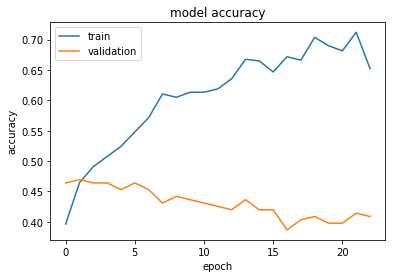

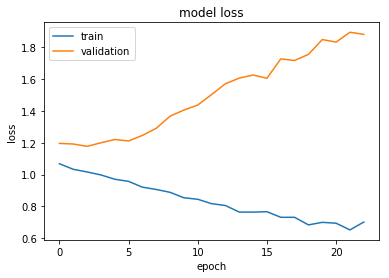

Time passed for training 0.809595811367035

TRAIN size: 719 	 VAL size: 181
TRAIN[:5]: [0 1 2 4 5] 	 VAL[:5]: [ 3 10 13 14 17]
TRAIN[-5:]: [891 892 893 897 899] 	 VAL[-5:]: [889 894 895 896 898]
[[ 0.0134  0.0171 -0.0344 ...  0.1915  0.2418  0.0458]
 [-0.3155 -0.0408 -0.2793 ...  0.1258  0.024  -0.219 ]
 [ 0.0681 -0.0378 -0.054  ...  0.1112 -0.1476 -0.0091]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
Train label distribution:  label
-1    130
 0    336
 1    253
Name: label, dtype: int64
Val label distribution:  label
-1    33
 0    84
 1    64
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_7 (Masking)          (None, None, 300)         0         
______________________________________________________________

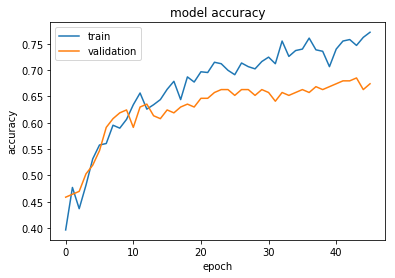

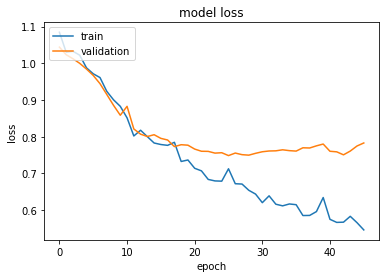

Time passed for training 1.4601300676663718

TRAIN size: 720 	 VAL size: 180
TRAIN[:5]: [1 2 3 4 6] 	 VAL[:5]: [ 0  5 16 18 35]
TRAIN[-5:]: [895 896 897 898 899] 	 VAL[-5:]: [865 868 879 885 887]
[[ 0.0304  0.007  -0.0708 ...  0.1801  0.2268  0.0424]
 [-0.3155 -0.0408 -0.2793 ...  0.1258  0.024  -0.219 ]
 [-0.0341 -0.0913 -0.2301 ...  0.0858  0.1339 -0.1326]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
Train label distribution:  label
-1    130
 0    336
 1    254
Name: label, dtype: int64
Val label distribution:  label
-1    33
 0    84
 1    63
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_8 (Masking)          (None, None, 300)         0         
_____________________________________________________________

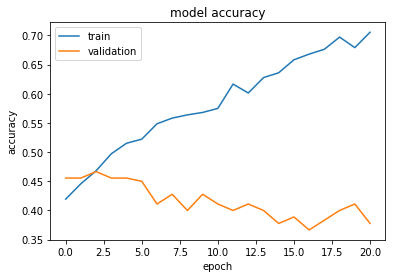

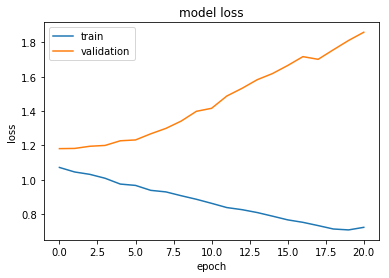

Time passed for training 0.7703432202339172

TRAIN size: 721 	 VAL size: 179
TRAIN[:5]: [0 1 3 4 5] 	 VAL[:5]: [ 2  9 12 20 21]
TRAIN[-5:]: [894 895 896 897 898] 	 VAL[-5:]: [863 870 876 892 899]
[[ 0.0134  0.0171 -0.0344 ...  0.1915  0.2418  0.0458]
 [-0.3155 -0.0408 -0.2793 ...  0.1258  0.024  -0.219 ]
 [ 0.0681 -0.0378 -0.054  ...  0.1112 -0.1476 -0.0091]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
Train label distribution:  label
-1    131
 0    336
 1    254
Name: label, dtype: int64
Val label distribution:  label
-1    32
 0    84
 1    63
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_9 (Masking)          (None, None, 300)         0         
_____________________________________________________________

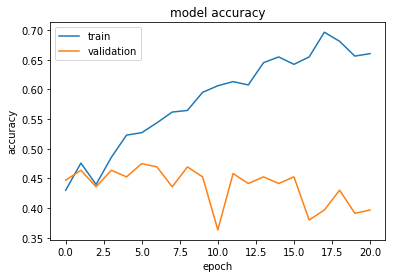

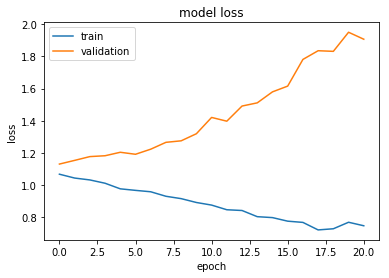

Time passed for training 0.7993659575780233

TRAIN size: 721 	 VAL size: 179
TRAIN[:5]: [0 1 2 3 5] 	 VAL[:5]: [ 4  7 15 28 33]
TRAIN[-5:]: [894 895 896 898 899] 	 VAL[-5:]: [884 888 890 891 897]
[[ 0.0134  0.0171 -0.0344 ...  0.1915  0.2418  0.0458]
 [-0.3155 -0.0408 -0.2793 ...  0.1258  0.024  -0.219 ]
 [ 0.0681 -0.0378 -0.054  ...  0.1112 -0.1476 -0.0091]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
Train label distribution:  label
-1    131
 0    336
 1    254
Name: label, dtype: int64
Val label distribution:  label
-1    32
 0    84
 1    63
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_10 (Masking)         (None, None, 300)         0         
_____________________________________________________________

In [ ]:
import nltk
from nltk.corpus import stopwords
from keras.layers.core import  ActivityRegularization
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers.core import Flatten
from keras.layers import Activation, TimeDistributed, Embedding, GRU, Bidirectional, LSTM

stop_words = set(stopwords.words('english'))

def plot_model_accuracy(history):
    """plot acc and loss for train and val"""
    filename = "hec" 
    filename = generate_model_name(filename + "-acc", max(history.history['val_acc']))
    fig = plt.figure()
    print(history.history.keys())
    print("best_val_acc", max(history.history['val_acc']))
    print("best_train_acc", max(history.history['acc']))
    print("lowest_val_loss", min(history.history['val_loss']))
    print("lowest_train_loss", min(history.history['loss']))
    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("model/" + filename + ".png") 
    
    # "Loss"
    fig = plt.figure()
    filename = "hec" 
    filename = generate_model_name(filename + "-loss", min(history.history['val_loss']))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("model/" + filename + ".png") 

def get_word_embedding(word):
    word = word.lower()
    if word in wordToVec:
        return wordToVec[word]
    else:
        return np.zeros(embedding_dimension,)
    
def get_sequence_embedding(words, max_seq_len):
    if len(words) <= max_seq_len:
        # Add padding
        x_seq = np.array([get_word_embedding(word) for word in words])
        x_seq = np.lib.pad(x_seq, ((0,max_seq_len-x_seq.shape[0]),(0,0)), 'constant')
    else:
        x_seq = []
        for i in range(max_seq_len):
            x_seq.append(get_word_embedding(words[i]))
        x_seq = np.array(x_seq)
    return x_seq
        
def convert_index_to_one_hot(y_train_index, num_of_classes):
    y_train = np.zeros((y_train_index.shape[0],num_of_classes))
    y_train[range(y_train_index.shape[0]),y_train_index] = 1
    return y_train


def generate_model_name(filename, best_acc_val):
    timestamp = str(time.time()).split(".")[0]
    best_acc_val = round(best_acc_val,4)
    filename += "-" + str(best_acc_val) + "-" + timestamp
    return filename

def get_words_withoutstopwords(words):
    words_without_stopwords = []
    for word in words:
        if word not in stop_words:
            words_without_stopwords.append(word)
    return words_without_stopwords

def load_dataset_StratifiedKFold(dfKFold, max_seq_len):
    sentences = []
    label_index = []
    num_of_classes = 0
    class_to_index = {}
    index_to_class = {}
    for index, row in dfKFold.iterrows():
        caption = row['caption']
        label = row['label']
        sentence = caption
        words = sentence.split(" ")
        words = get_non_stop_words(words)
        sentence_embedding = get_sequence_embedding(words, max_seq_len)
        sentences.append(sentence_embedding)
        if label in class_to_index:
            label_index.append(class_to_index[label])
        else:
            num_of_classes += 1
            class_to_index[label] = num_of_classes - 1
            index_to_class[num_of_classes - 1] = label
            label_index.append(class_to_index[label])
    X_train = np.array(sentences)
    y_train = np.array(label_index)
    return (X_train, y_train, num_of_classes)


def get_non_stop_word_count(words):
    count = 0
    for word in words:
        if word not in stop_words:
            count += 1
    return count


def get_non_stop_words(words):
    non_stop_words = []
    for word in words:
        if word not in stop_words:
            non_stop_words.append(word)
    return non_stop_words

def change_label_str_to_int(labelStr):
    if labelStr == "negative":
        return -1
    elif  labelStr == "neutral":
        return 0
    elif  labelStr == "positive":
        return 1

def change_label_str_to_int_binary(labelStr):
    """this is only for binary classification, negative sentiment has value 0, positive sentiment has value 1"""
    if labelStr == "negative":
        return 0
    elif  labelStr == "neutral":
        raise "Neutral Should not exist"
    elif  labelStr == "positive":
        return 1
    else:
        raise labelStr+ " Should not exist"

def get_df_for_binary_classification():
    df = pd.read_csv(dataset_path, header=0, sep="|")
    # Doing only binary classification
    df = df[(df.label == "negative") | (df.label == "positive")]
    df = df.reset_index()
    df["label"] = df["label"].apply(lambda x: change_label_str_to_int_binary(x))
    df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
    return df


def build_model(isBinaryClassification, max_seq_len, num_of_classes, embedding_dim, hidden_layer_dim, dropout, recurrent_dropout, final_activation): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, embedding_dim)))
    #model.add(Dropout(0.1))

    #, dropout=dropout, recurrent_dropout=recurrent_dropout
    model.add(Bidirectional(GRU(16,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(GRU(4, dropout=dropout, recurrent_dropout=recurrent_dropout))) # , dropout=0.1, recurrent_dropout=0.1
    #model.add(Dropout(dropout))
    


    #, dropout=dropout, recurrent_dropout=recurrent_dropout
    #model.add(BidirectionalLSTM(128,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    #model.add(Bidirectional(LSTM(128, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    #model.add(Dropout(dropout))
    
    model.add(Dense(num_of_classes, activation=final_activation))

    if isBinaryClassification:
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

def train_StratifiedKFold(isBinaryClassification):
    """StratifiedKFold cross-validation to solve class imbalance issue"""
    df = pd.read_csv(dataset_path, header=0, sep="|")
    df["label"] = df["label"].apply(lambda x: change_label_str_to_int(x))
    df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
    print(df['caption'].head(5))
    print(df['label'].head(5))
    # Doing only binary classification
    if isBinaryClassification:
        df = get_df_for_binary_classification()
    
    X = df["caption"]
    y = df["label"]
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    printCnt = 5
    cvscores = []
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        start = time.time()
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("TRAIN[:5]:", train_indices[:printCnt], "\t VAL[:5]:", val_indices[:printCnt])
        print("TRAIN[-5:]:", train_indices[-printCnt:], "\t VAL[-5:]:", val_indices[-printCnt:])
        X_train, X_val = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        dfTrain = pd.concat([X_train, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        X_train, y_train_index, num_of_classes = load_dataset_StratifiedKFold(dfTrain, max_seq_len)
        y_train = convert_index_to_one_hot(y_train_index, num_of_classes) 
        print(X_train[0])
        print(y_train[0])
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        dfVal= pd.concat([X_val, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        
        X_val, y_val_index, _ = load_dataset_StratifiedKFold(dfVal,max_seq_len)
        y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
        print("Val label distribution: ",dfVal.groupby('label').label.count())
        
        if isBinaryClassification:
            final_activation ='sigmoid'
        else:
            final_activation ='softmax'
        print("final_activation",final_activation)
        model = build_model(isBinaryClassification,
                            max_seq_len,
                            num_of_classes, 
                            embedding_dim=300, 
                            hidden_layer_dim=40, 
                            dropout=0.5, 
                            recurrent_dropout=0.65,# 0.3
                            final_activation=final_activation
                            )
        plot_model(model, to_file= 'model/model.png', show_shapes=True, show_layer_names=True)#
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=5, 
                                  min_lr=0.001)
        
        history = {}
        filename = ""
        # checkpoint
        filepath="model/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20)
        callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=16,# 64 seems fine, 32 is better 
                      epochs=100, 
                      verbose=1, 
                      validation_data = (X_val, y_val),
                      shuffle=True,
                      callbacks=callbacks_list)        
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        print("best_val_acc: ", best_val_acc)
        filename = "hec" 
        filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        cvscores.append(best_val_acc)
        plot_model_accuracy(history)
        end = time.time()
        print("Time passed for training", (end-start)/60)
    print("Cross-validation results: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    return history


dataset_path = human_output_caption_to_label_csv_path
kfold_splits = 5
# dataset_path = auto_output_caption_to_label_csv_path


embedding_dimension = 300
class_to_index = {}
index_to_class = {}
#max_seq_len = 40
start = time.time()
isBinaryClassification = False
history = train_StratifiedKFold(isBinaryClassification) 
#dataset_path = caption_to_label_dataset_path + "/" +'human-train.csv'
#val_dataset_path = caption_to_label_dataset_path + "/" +'human-val.csv'
#history = train()
end = time.time()
print("Total time passed for training", (end-start)/60)


# K-fold cross validation

As this vanilla k-fold does not take into account the class imbalance, is not used any more.

In [5]:
# def load_dataset(file_path):
#     df = pd.read_csv(file_path, sep="|")
#     sentences = []
#     label_index = []
#     num_of_classes = 0
#     for i in range(len(df)):
#         sentence = df.iloc[:,0][i]  # first column of data frame
#         words = sentence.split(" ")
#         sentence_embedding = get_sequence_embedding(words, max_seq_len)
#         sentences.append(sentence_embedding)
#         label = df.iloc[:,1][i]  # second column of data frame
#         if label in class_to_index:
#             label_index.append(class_to_index[label])
#         else:
#             num_of_classes += 1
#             class_to_index[label] = num_of_classes - 1
#             index_to_class[num_of_classes - 1] = label
#             label_index.append(class_to_index[label])
#     X_train = np.array(sentences)
#     y_train = np.array(label_index)
#     return (X_train, y_train, num_of_classes)


# def train():
#     X_train, y_train_index, num_of_classes = load_dataset(dataset_path)
#     y_train = convert_index_to_one_hot(y_train_index, num_of_classes) 
    
#     print('X_train shape : %s' % (X_train.shape,))
#     print('y_train shape : %s' % (y_train.shape,))
#     print('number of classes : %d' % num_of_classes)
#     print(X_train[0])
#     print(y_train[0])
#     print(index_to_class)

#     X_val, y_val_index, _ = load_dataset(val_dataset_path)
#     y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
    
#     model = _build_model(num_of_classes, 
#                          embedding_dim=300, 
#                          hidden_layer_dim=64, 
# #                          dropout=0.65, 
# #                          recurrent_dropout=0.65,
#                          dropout=0.7, 
#                          recurrent_dropout=0.5,
#                          final_activation='softmax')
    
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                                   factor=0.03, 
#                                   patience=15, 
#                                   min_lr=0.00001, verbose=1)
    
#     history = {}
#     filename = ""
#     # checkpoint
#     filepath="model/weights.best.h5"
#     checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#     early_stopping = EarlyStopping(monitor='val_loss', patience=20)
#     callbacks_list = [ checkpoint, early_stopping] #reduce_lr, 
#     with tf.Session() as sess:
#         history = model.fit(x=X_train,
#                   y=y_train, 
#                   batch_size=32, 
#                   epochs=300, 
#                   verbose=1, 
#                   validation_data = (X_val, y_val),
#                   shuffle=True
#                   ,callbacks=callbacks_list)        
#         val_acc_list = history.history['val_acc']
#         best_val_acc =  max(val_acc_list)
#         filename = "hec" 
#         filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
#         os.rename(filepath, filename)
    
#     best_val_acc = -1
#     val_acc_list = history.history['val_acc']
#     best_val_acc =  max(val_acc_list)
#     print("best_val_acc: ", best_val_acc)
#     #filename = generate_model_name(filename, best_val_acc)
#     print("filename",filename)
#     plot_model(model, to_file= filename +'.png', show_shapes=True, show_layer_names=True)#
#     return history



# # Not sued, as this cross validation does not take into account the class inbalance
# ## Create k-fold cross validation
# from sklearn.model_selection import KFold
# dataset_path = human_output_caption_to_label_csv_path
# class_to_index = {}
# index_to_class = {}
# kfold_splits = 5
# # dataset_path = auto_output_caption_to_label_csv_path
# def train_k_fold():
#     X, y_index, num_of_classes = load_dataset(dataset_path)
#     print('X shape : %s' % (X.shape,))
#     print('y_index shape : %s' % (y_index.shape,))
#     print('number of classes : %d' % num_of_classes)

#     y = convert_index_to_one_hot(y_index, num_of_classes) 
#     print('y shape : %s' % (y.shape,))
#     print(X[0])
#     print(y[0])
#     print(index_to_class)
    
#     kf = KFold(n_splits=kfold_splits)
#     kf.get_n_splits(X)
#     print(kf)  
#     cvscores = []
#     printCnt = 5
#     for train_index, val_index in kf.split(X):
#         print("TRAIN:", len(train_index), "VAL:", len(val_index))
#         print("TRAIN:", train_index[:printCnt], "VAL:", val_index[:printCnt])
#         print("TRAIN:", train_index[-printCnt:], "VAL:", val_index[-printCnt:])
#         X_train, X_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         model = _build_model(num_of_classes, 
#                              embedding_dim=300, 
#                              hidden_layer_dim=64, 
#                              dropout=0.5, 
#                              recurrent_dropout=0.5,
#                              final_activation='softmax')

#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                                       factor=0.03, 
#                                       patience=15, 
#                                       min_lr=0.00001, verbose=1)

#         history = {}
#         filename = ""
#         # checkpoint
#         filepath="model/weights.best.h5"
#         #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#         #early_stopping = EarlyStopping(monitor='val_loss', patience=20)
#         #callbacks_list = [ checkpoint, early_stopping] #reduce_lr, 
#         history = model.fit(x=X_train,
#                           y=y_train, 
#                           batch_size=32, 
#                           epochs=100, 
#                           verbose=1
#                           )# ,callbacks=callbacks_list        

#         # evaluate the model
#         scores = model.evaluate(X[val_index], y[val_index], verbose=0)
#         print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#         cvscores.append(scores[1] * 100)
#     print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
#     return cvscores
# #         val_acc_list = history.history['val_acc']
# #         best_val_acc =  max(val_acc_list)
# #         filename = "hec" 
# #         filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
# #         os.rename(filepath, filename)

# #         best_val_acc = -1
# #         val_acc_list = history.history['val_acc']
# #         best_val_acc =  max(val_acc_list)
# #         print("best_val_acc: ", best_val_acc)
# #         #filename = generate_model_name(filename, best_val_acc)
# #         print("filename",filename)
# #         plot_model(model, to_file= filename +'.png', show_shapes=True, show_layer_names=True)#
# #         return history

# cvscores = train_k_fold()

## Create Train and Val set

Not used, as using Stratified k-fold cross-validation

In [6]:
# from shutil import rmtree

# trainValSplitRatio = 0.75

# def delete_file(filePath):
#     if os.path.isfile(filePath):
#         os.remove(filePath)

# def create_train_dev_set(isRunningForHumanCaption, dataset_path, delimeter="|"):
#     if isRunningForHumanCaption:
#         caption_csv_path = human_output_caption_to_label_csv_path
#         prefix = "human"
#     else:
#         caption_csv_path = auto_output_caption_to_label_csv_path
#         prefix = "auto"
    
    
#     dataset_groups=["train", "val"]
#     if not os.path.isdir(dataset_path):
#         os.makedirs(dataset_path)

#     captionToLabelDf = dt.read_caption_to_label_csv_into_dataframe(caption_csv_path)
#     captionToLabelDf.shape
#     captionToLabelDf.head()

#     random.seed(1)
#     trainCount = 0
#     valCount = 0
#     for index, row in captionToLabelDf.iterrows():
#         caption = row['caption']
#         label = row['label']
#         prob = random.uniform(0, 1)
#         if prob > trainValSplitRatio:
#             dGroup = "val"
#             valCount += 1
#         else:
#             dGroup = "train"
#             trainCount += 1
#         filename = prefix + "-" + dGroup + ".csv"
#         filePath = dataset_path + filename
#         if index == 0:
#             trainFile = prefix + "-" + "train" + ".csv"
#             delete_file(dataset_path + trainFile)
#             valFile = prefix + "-" + "val" + ".csv"
#             delete_file(dataset_path + valFile)
            
#         with open(filePath,  'a', encoding="utf8") as f:
#             f.write(caption + delimeter + label + "\n")
#     print("Train count: ", trainCount)
#     print("Val count: ", valCount)

    
# caption_to_label_dataset_path = "dataset/caption-lstm/"

# # Create Train and Val set for human generated captions
# isRunningForHumanCaption = True
# create_train_dev_set(isRunningForHumanCaption, caption_to_label_dataset_path)

# # Create Train and Val set for auto generated captions
# isRunningForHumanCaption = False
# create_train_dev_set(isRunningForHumanCaption, caption_to_label_dataset_path)